# Import Libraries & Data (review_polarity)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.6 MB/s eta 0:00:00


In [4]:
!pip install tqdm pandas nltk pyspellchecker emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 23.5 MB/s eta 0:00:00


In [14]:
from tqdm import tqdm
import os
import pandas as pd
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
import string
import re
from spellchecker import SpellChecker
import emoji
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.sparse import hstack
import contractions
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC

In [6]:
base_path = '/content/drive/MyDrive/txt_sentoken'
neg_path = os.path.join(base_path, 'neg')
pos_path = os.path.join(base_path, 'pos')

neg_reviews = []
for file in os.listdir(neg_path):
    with open(os.path.join(neg_path, file), 'r', encoding='utf-8') as f:
        neg_reviews.append(f.read())

pos_reviews = []
for file in os.listdir(pos_path):
    with open(os.path.join(pos_path, file), 'r', encoding='utf-8') as f:
        pos_reviews.append(f.read())

df_txt_sentoken = pd.DataFrame({
    'text': neg_reviews + pos_reviews,
    'label': [0]*len(neg_reviews) + [1]*len(pos_reviews)
})

print(df_txt_sentoken.head())
print(df_txt_sentoken['label'].value_counts())

                                                text  label
0  plot : two teen couples go to a church party ,...      0
1  the happy bastard's quick movie review \ndamn ...      0
2  it is movies like these that make a jaded movi...      0
3   " quest for camelot " is warner bros . ' firs...      0
4  synopsis : a mentally unstable man undergoing ...      0
label
0    1000
1    1000
Name: count, dtype: int64


# Preprocessing

In [7]:
import re
import string
import contractions
import spacy
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Load spaCy model
nlp = spacy.load("en_core_web_sm")  # You can use 'en_core_web_md' for better results

# Sample slang dictionary (you can expand this)
slang_dict = {
    "u": "you", "ur": "your", "lol": "laugh out loud", "idk": "i do not know",
    "brb": "be right back", "btw": "by the way", "imo": "in my opinion",
    "omg": "oh my god", "lmk": "let me know", "smh": "shaking my head"
}

# Optional: Spelling correction using TextBlob or SymSpell (not included here due to slowness)
# from textblob import TextBlob

# Expand slang
def expand_slang(text, slang_dict):
    words = text.split()
    return ' '.join([slang_dict.get(w, w) for w in words])

# Preprocessing function
def preprocess_text(text, rare_words=set()):
    # Lowercase
    text = text.lower()

    # Expand contractions (e.g., don't -> do not)
    text = contractions.fix(text)

    # Expand slang
    text = expand_slang(text, slang_dict)

    # Remove digits and punctuation
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()

    # Lemmatization with spaCy (better than NLTK)
    doc = nlp(text)
    lemmatized = []
    for token in doc:
        word = token.text
        # OPTIONAL: Apply spelling correction only to rare words
        if word in rare_words:
            pass  # Add correction logic here if needed
        lemmatized.append(token.lemma_)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    cleaned = [word for word in lemmatized if word not in stop_words]

    return ' '.join(cleaned)


# Compute word frequencies to identify rare words
all_words = ' '.join(df_txt_sentoken['text'].str.lower()).split()
word_freq = Counter(all_words)
rare_words = {word for word, freq in word_freq.items() if freq == 1}

# Apply the preprocessing
df_txt_sentoken['clean_text'] = df_txt_sentoken['text'].apply(lambda x: preprocess_text(str(x), rare_words))

final_df = df_txt_sentoken[['clean_text', 'label']]

# View result
print(final_df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                          clean_text  label
0  plot two teen couple go church party drink dri...      0
1  happy bastard quick movie review damn yk bug g...      0
2  movie like make jade movie viewer thankful inv...      0
3  quest camelot warner bros first featurelength ...      0
4  synopsis mentally unstable man undergo psychot...      0


In [8]:
final_df.shape

(2000, 2)

# Feature Extraction

In [9]:
# TF-IDF Vectorization (Unigrams + Bigrams)
tfidf = TfidfVectorizer(min_df=5, max_features=10000, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(final_df['clean_text'])
y = final_df['label']

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# Model

In [10]:
# ==========================
# Logistic Regression
# ==========================
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
print("Best Logistic Regression (GridSearchCV) Accuracy:", grid.score(X_test, y_test))

Best Logistic Regression (GridSearchCV) Accuracy: 0.8425


In [18]:
# ==========================
# LinearSVC
# ==========================
svc = LinearSVC()
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
print("LinearSVC Accuracy:", accuracy_score(y_test, y_pred_svc))
print("Classification Report:\n", classification_report(y_test, y_pred_svc))

# ==========================
# Random Forest
# ==========================
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

LinearSVC Accuracy: 0.84
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.81      0.84       200
           1       0.82      0.86      0.84       200

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400

Random Forest Accuracy: 0.825
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.84      0.83       200
           1       0.84      0.81      0.82       200

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400



In [16]:
# ==========================
# Ensemble Learning
# ==========================
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[
    ('lr', LogisticRegression(max_iter=1000)),
    ('nb', MultinomialNB()),
    ('rf', RandomForestClassifier())
], voting='soft')  # Use 'hard' or 'soft'

ensemble.fit(X_train, y_train)
preds = ensemble.predict(X_test)
print("Ensemble Accuracy:", accuracy_score(y_test, preds))

Ensemble Accuracy: 0.845


In [19]:
import joblib

# Save the trained ensemble model
joblib.dump(ensemble, 'ensemble_model.pkl')

print("Model saved successfully!")

Model saved successfully!


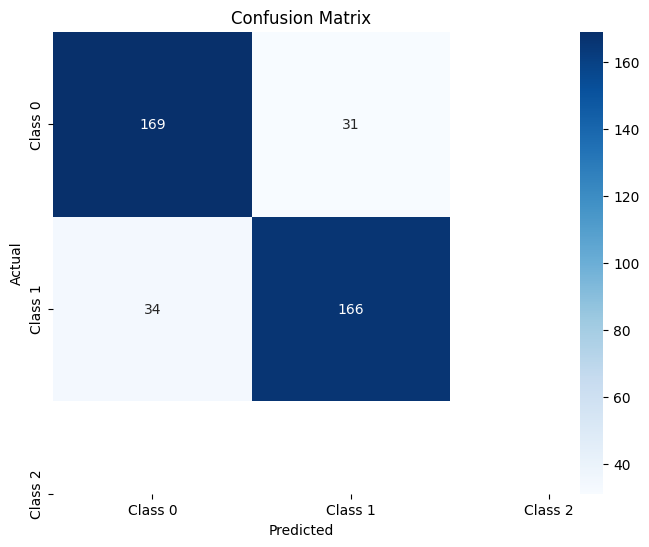

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, preds)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [21]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       200
           1       0.84      0.83      0.84       200

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400

